In [221]:
import matplotlib.font_manager
from IPython.core.display import HTML
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random 
import csv
from IPython.display import display, Math
from numpy import unravel_index
from scipy.optimize import curve_fit

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))

plt.rcParams["font.family"] = "TeX Gyre Schola Math"

print("Corrected Transverse Velocities")

Corrected Transverse Velocities


## The systematics are the following

In [222]:
WestSyst = [-0.0224, -0.0122]
NortSyst = [-0.002, -0.0041]
SoutSyst = [-0.0061, -0.0051]
EastSyst = [0.0112, -0.0031]

## Import the data

### Importing the data from Gaia

In [223]:
def OutCVSGaia(name):
    #___ Description_____________________________________________________________________________________
    #Arguments:: name of the file to be read
    #Returns:: list of lists with either all the velocity components as seen from Earth, or  with all the 
    #         positions of the ellipse for the model
    #____________________________________________________________________________________________________
  
    LIST1, LIST2, LIST3, LIST4, LIST5, LIST6, LIST7 = [], [], [], [], [], [], []
    with open('ThisIsTheData/' + name + '.csv', 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            LIST1.append(float(row[0])) #x position
            LIST2.append(float(row[1])) #y position
            LIST3.append(float(row[2])) #pmra
            LIST4.append(float(row[3])) #sigma on the pmra
            LIST5.append(float(row[4])) #pmdec
            LIST6.append(float(row[5])) #sigma on the pmdec
            LIST7.append(float(row[6])) #pmra and pmdec correlations
            
    return LIST1, LIST2, LIST3, LIST4, LIST5, LIST6, LIST7

In [224]:
#We first import all the position of the different stars
x_All, y_All, pmra_All, pmra_sig_All, pmdec_All, pmdec_sig_All, pm_corr_All        = OutCVSGaia('AllStars')
x_Blue, y_Blue, pmra_Blue, pmra_sig_Blue, pmdec_Blue, pmdec_sig_Blue, pm_corr_Blue = OutCVSGaia('BlueStars')
x_Red, y_Red, pmra_Red, pmra_sig_Red, pmdec_Red, pmdec_sig_Red, pm_corr_Red        = OutCVSGaia('RedStars')

### Organising the data from the Gaia data

In [225]:
def OrganiseGaiaData(x, y, pmra, pmra_e, pmdec, pmdec_e, pm_corr):
    #___ Description_____________________________________________________________________________________
    #Arguments:: gives all the relevant quantities
    #Returns:: list with all the different significant quantities localised in it
    #____________________________________________________________________________________________________
     
    GaiaData = []
    
    GaiaData.append(x)
    GaiaData.append(y)
    GaiaData.append(pmra)
    GaiaData.append(pmra_e)
    GaiaData.append(pmdec)
    GaiaData.append(pmdec_e)
    GaiaData.append(pm_corr)
    
    return GaiaData

In [226]:
GaiaDataAll  = OrganiseGaiaData(x_All, y_All, pmra_All, pmra_sig_All, pmdec_All, pmdec_sig_All, pm_corr_All)
GaiaDataBlue = OrganiseGaiaData(x_Blue, y_Blue, pmra_Blue, pmra_sig_Blue, pmdec_Blue, pmdec_sig_Blue, pm_corr_Blue)
GaiaDataRed  = OrganiseGaiaData(x_Red, y_Red, pmra_Red, pmra_sig_Red, pmdec_Red, pmdec_sig_Red, pm_corr_Red)

## Selection of the different regions

In [227]:
def ElContaminant(Ra, Dec, Num): 
    #___ Description_____________________________________________________________________________________
    #Arguments:: It separates the space in 4 quadrant here being N(Num=1), S(Num=2), E(Num=3), W(Num=0). 
    #           RA and DEC position of objects.
    #Returns:: returns either true or false if the object is in one of the four quadrant or not
    #____________________________________________________________________________________________________   

    Result = False
    Sign = [[1, 1], [1, -1], [-1, 1], [-1, -1]]
    
    PA     = 45*np.pi/180 #radians, position angle
    
    AngDia2 = 9 #degrees, inclination angle
    A     = AngDia2
    B     = AngDia2
    
    R_rot = np.array([[np.cos(PA), -np.sin(PA)], [np.sin(PA), np.cos(PA)]])

    Ell_rot = np.dot(R_rot, [Ra, Dec])
    if (Ell_rot[0]**2)/(A**2) + (Ell_rot[1]**2)/(B**2) <= 1: #Keeps every stars in the big ellipse
        if Sign[Num][0]*Ell_rot[0]*np.cos(PA) < 0 and Sign[Num][1]*Ell_rot[1]*np.sin(PA) < 0: #Linear selection along lines
            Result = True
                
    return Result

In [228]:
def Quadrant(Data, Number, Systematics):
    #___ Description_____________________________________________________________________________________
    #Arguments:: Astropy table in which we find RA and DEC coordinates and a number (see ElContaminant)
    #Returns:: list of the coordinates in the choosen quadrant and also the corresponding pm...
    #____________________________________________________________________________________________________
    for i in range(len(Data[0])):
        test = ElContaminant(Data[0][i], Data[1][i], Number)
        if test == True:
            Data[2][i] += Systematics[0]
            #Data[3][i] *= 2 #Just as a check to ensure the uncertainties are well determine
            Data[4][i] += Systematics[1]

In [229]:
#Adding the systematics for the blue sample
Quadrant(GaiaDataBlue, 0, WestSyst)
Quadrant(GaiaDataBlue, 1, NortSyst)
Quadrant(GaiaDataBlue, 2, SoutSyst)
Quadrant(GaiaDataBlue, 3, EastSyst)

#Adding the systematics for the red sample    
Quadrant(GaiaDataRed, 0, WestSyst)
Quadrant(GaiaDataRed, 1, NortSyst)
Quadrant(GaiaDataRed, 2, SoutSyst)
Quadrant(GaiaDataRed, 3, EastSyst)

### Importing the data from the model

In [230]:
def OutCVSModel(name):
    #___ Description_____________________________________________________________________________________
    #Arguments:: name of the file to be read
    #Returns:: list of lists with either all the velocity components as seen from Earth, or  with all the 
    #         positions of the ellipse for the model
    #____________________________________________________________________________________________________
  
    LIST1, LIST2, LIST3 = [], [], []
    if name != "model":
        with open('ThisIsTheData/' + name + '.csv', 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                LIST1.append([float(row[0]), float(row[1])])
        return LIST1
    
    else:
        with open('ThisIsTheData/' + name + '.csv', 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                LIST1.append(float(row[0]))
                LIST2.append(float(row[1]))
                LIST3.append(-float(row[2]))
        return LIST1, LIST2, LIST3        

In [231]:
#Reading the cvs files
xb = OutCVSModel('x_edges') #all x the edges of the bins
yb = OutCVSModel('y_edges') #all the y edges of the bins
vb = OutCVSModel('vel')     #all the heliocentric velocities of the bins

x_model, y_model, z_model = OutCVSModel("model")

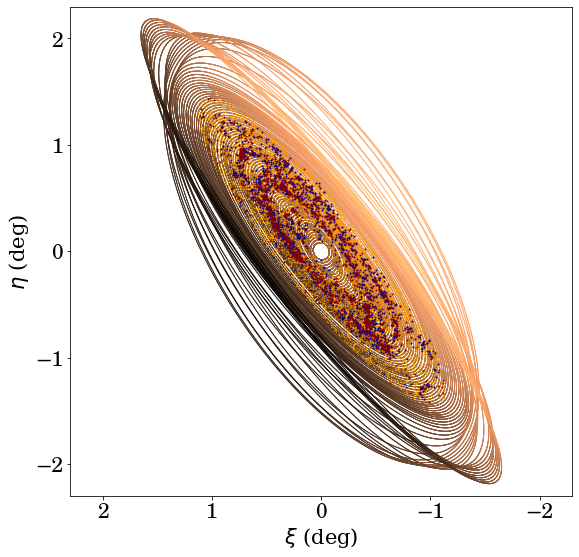

In [232]:
plt.figure(figsize=(9, 9))
#Plot the background:
plt.scatter(x_model, y_model, c=z_model, cmap='copper', s=1, linewidth=0)

#Plot of the stars coming from gaia
plt.scatter(x_All, y_All, s=0.1, color='orange')
plt.scatter(x_Blue, y_Blue, s=0.9, color='darkblue')
plt.scatter(x_Red, y_Red, s=0.9, color='darkred')

plt.xlabel(r'$\xi$ (deg)', fontname = 'Serif', size = 21)
plt.ylabel(r'$\eta$ (deg)', fontname = 'Serif', size = 21)
plt.xlim(-2.3, 2.3)
plt.ylim(-2.3, 2.3)
plt.xticks(fontsize = 21)
plt.yticks(fontsize = 21)
plt.gca().invert_xaxis()
#plt.savefig('Superimposed.png', dpi=500)
plt.show()

## Associating to each star the velocity they should have from the model

In [233]:
def FindBin(x, y, x_intervals, y_intervals, vel):
    #___ Description_____________________________________________________________________________________
    #Arguments:: coordinates of the point, lists of the intervals (along x and y) and the list of the 
    #           components of the velocity along each axis
    #Returns:: returns the components of the velocity in the bin in mas/yr
    #____________________________________________________________________________________________________
     
    #We first determine in which bin the point/star is located
    count = 0
    for i in range(len(x_intervals)):
        if x > x_intervals[i][0] and x < x_intervals[i][1]:
            if y > y_intervals[i][0] and y < y_intervals[i][1]:
                count = i    
                
    #Let's convert the velocity from km/s to mas/yr
    RadDist = 780*3.08E16 #Radial distance from M31 in km
    YrToSec = 365.25*86400 #Years to seconds
    
    pm_ra  = ((vel[count][0]*YrToSec)/(RadDist*4.84814E-9))
    pm_dec = (vel[count][1]*YrToSec)/(RadDist*4.84814E-9)

    return pm_ra, pm_dec

In [234]:
def OrganiseModelData(x_stars, y_stars, x_bounds, y_bounds, vel):
    #___ Description_____________________________________________________________________________________
    #Arguments:: 'x' and 'y_stars' are lists of the coordinates of the star for which we want the proper
    #           motion. 'x' and 'y_bounds' are the limits of the bins of the model and 'vel' the 
    #           velocities associated in each of those
    #Returns:: returns a list with all the proper motions of the stars in mas/yr
    #____________________________________________________________________________________________________

    ModelData = [[], []]
        
    for i in range(len(x_stars)):
        Temporary = FindBin(x_stars[i], y_stars[i], xb, yb, vb)
        ModelData[0].append(Temporary[0])
        ModelData[1].append(Temporary[1])
    
    return ModelData

In [235]:
ModelDataAll  = OrganiseModelData(GaiaDataAll[0], GaiaDataAll[1], xb, yb, vb)
ModelDataBlue = OrganiseModelData(GaiaDataBlue[0], GaiaDataBlue[1], xb, yb, vb)
ModelDataRed  = OrganiseModelData(GaiaDataRed[0], GaiaDataRed[1], xb, yb, vb)

## Estimation of the bulk motion 

In [241]:
class LikelihooD():
    #____Constructor::___________________________________________________________________________________
    def __init__(self, NbModels, GaiaData, ModelData, MockData):
        self.NbModels = NbModels
    
        self.mu_ra_gaia       = GaiaData[2]
        self.mu_ra_sig_gaia   = GaiaData[3]
        self.mu_dec_gaia      = GaiaData[4]
        self.mu_dec_sig_gaia  = GaiaData[5]
        self.corr             = GaiaData[6]
        
        self.mu_ra_model  = ModelData[0]
        self.mu_dec_model = ModelData[1]
        
        if len(MockData) != 0:
            self.mu_ra_gaia  = MockData[0]
            self.mu_dec_gaia = MockData[1]
           
    #____Methods::_______________________________________________________________________________________
    def Execute(self):
        #Let's first execute the command that will create the lists of free parameters (f.p.)
        self.FreeParameters()
        
        #Create the function that will contain the values of the likelihood for a given f.p. couple                     
        self.LikelihoodList = np.zeros((len(self.pm_dec_M31), len(self.pm_ra_M31)))
        for i in range(len(self.pm_dec_M31)):
            for j in range(len(self.pm_ra_M31)):
                for k in range(len(self.mu_ra_gaia)):
                    self.LikelihoodList[j,i] += (1 - 0.027)*LikelihoodCFunctionCorr(self.pm_ra_M31[i], self.pm_dec_M31[j], 
                                                                    self.mu_ra_model[k], self.mu_dec_model[k],
                                                                    self.mu_ra_sig_gaia[k], self.mu_dec_sig_gaia[k], 
                                                                    self.mu_ra_gaia[k], self.mu_dec_gaia[k], self.corr[k])
                    
                    self.LikelihoodList[j,i] += 0.027*LikelihoodCFunctionCorr(self.pm_ra_M31[i], self.pm_dec_M31[j], 
                                                                    0.00015, -0.00269,
                                                                    self.mu_ra_sig_gaia[k], self.mu_dec_sig_gaia[k], 
                                                                    self.mu_ra_gaia[k], self.mu_dec_gaia[k], self.corr[k])

        self.Renormalisation()  
        
        self.OneDimGaussian()
        
        return self.ra_max, self.dec_max
                
    def FreeParameters(self):
        self.pm_ra_M31  = np.linspace(0., 0.1, self.NbModels) 
        self.pm_dec_M31 = np.linspace(-0.1, 0., self.NbModels)
        
        self.space = (self.pm_ra_M31[-1] - self.pm_ra_M31[-2])
    
    def Renormalisation(self):
        max_likeli = np.max(self.LikelihoodList)
        for i in range(len(self.pm_ra_M31)):
            for j in range(len(self.pm_dec_M31)):
                self.LikelihoodList[j,i] -= max_likeli
                self.LikelihoodList[j,i] = np.exp(self.LikelihoodList[j,i])
        
        ra_max, dec_max = unravel_index(self.LikelihoodList.argmax(), self.LikelihoodList.shape)
        
        self.ra_max, self.dec_max = self.pm_ra_M31[dec_max], self.pm_dec_M31[ra_max]
             
    def OneDimGaussian(self):
        self.x_gaus, self.y_gaus = [], []
        for i in range(self.NbModels):
            line = self.LikelihoodList[i, :]
            self.x_gaus.append(np.sum(line))
            
            row = self.LikelihoodList[: ,i]
            self.y_gaus.append((np.sum(row)))
            
    def Uncertainties(self, x_axis, y_axis):
        def gaussian(x, a, x0, sigma):
            return a * np.exp(-(x - x0)**2 / (2 * sigma**2))
        popt, pcov = curve_fit(gaussian, x_axis, y_axis)
        
        return popt
             
    def Plot(self):
        def scatter_hist(ax, ax_histx, ax_histy):
            ax_histx.tick_params(axis="x", labelleft=False, labelsize=0, labelbottom=False) 
            ax_histy.tick_params(axis="y", labelleft=False, labelsize=0, labelbottom=False)
                       
            ax.contour([x * 1000 for x in self.pm_ra_M31], [x * 1000 for x in self.pm_dec_M31], self.LikelihoodList, 
                    levels=[np.exp(-0.5*11.8), np.exp(-0.5*6.17), np.exp(-0.5*2.3)],  
                    colors=['#ff6200', 'darkred', 'black'])
            ax.scatter(self.ra_max*1000, self.dec_max*1000, c="#f6b515")
            ax.tick_params(axis='both', which='major', labelsize=15)
            ax.set_xlabel(r'$\mu_{\alpha, M31}$ ($\mu$as.yr$^{-1})$', fontname = 'Serif', size = 19)
            ax.set_ylabel(r'$\mu_{\delta, M31}$ ($\mu$as.yr$^{-1})$', fontname = 'Serif', size = 19)
            
            ax.set_xlim(ax.get_xlim()[::-1])

            self.x_bins, self.y_bins = [], [] 
            for i in range(len(self.pm_dec_M31)):
                self.x_bins.append(self.pm_ra_M31[i] - self.space/2)
            for i in range(len(self.pm_ra_M31)):
                self.y_bins.append(self.pm_dec_M31[i] - self.space/2)

            #Plot of the RA histogram
            colors = self.y_gaus / np.max(self.y_gaus)
            ax_histx.bar([x * 1000 for x in self.x_bins], self.y_gaus, width=self.space*1000, align='edge', 
                         edgecolor='black', color='darkred', alpha=0.7)
            ax_histx.set_yticklabels([])
            self.popt_ra = self.Uncertainties(self.x_bins, self.y_gaus) #deduction std
            
            #Plot of the DEC histogram
            colors = self.x_gaus / np.max(self.x_gaus)
            ax_histy.barh([x * 1000 for x in self.y_bins], self.x_gaus, height=self.space*1000, align='edge', 
                          edgecolor='black', color='darkblue', alpha=0.7)
            ax_histy.set_xticklabels([])
            self.popt_dec = self.Uncertainties(self.y_bins, self.x_gaus) #deduction std
        
        fig = plt.figure(figsize=(8, 9))
        gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4),
                              left=0.1, right=0.9, bottom=0.1, top=0.9,
                              wspace=0.05, hspace=0.05)

        ax = fig.add_subplot(gs[1, 0])
        ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
        ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

        scatter_hist(ax, ax_histx, ax_histy)
        
        #Because of how I build the array the dec actually corresponds to the ra and vice versa 
        print("Maximum of likelihood:")
        display(Math(r"\mu_{\alpha, M31} = " + str(round(self.ra_max*1000, 1)) + "\pm" + str(
            round(abs(self.popt_ra[2])*1000, 1)) + r"\ \mu as/yr"))
        display(Math(r"\mu_{\delta, M31} = " + str(round(self.dec_max*1000, 1)) + "\pm" + str(
            round(abs(self.popt_dec[2])*1000, 1))  + r"\ \mu as/yr"))

Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

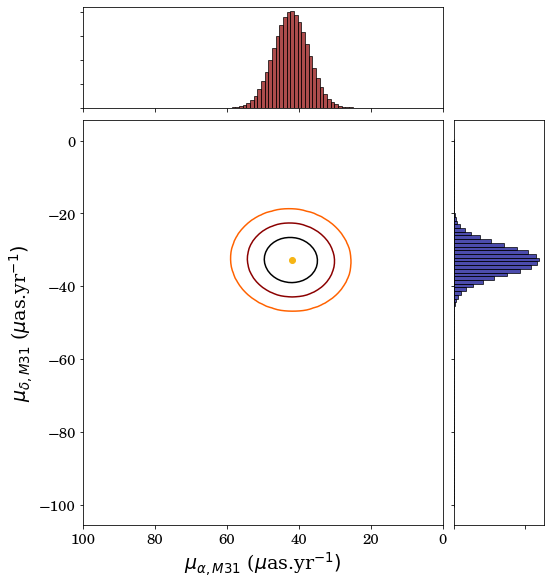

In [242]:
ObjLike = LikelihooD(99, GaiaDataBlue, ModelDataBlue, [])
ObjLike.Execute()
ObjLike.Plot()

Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

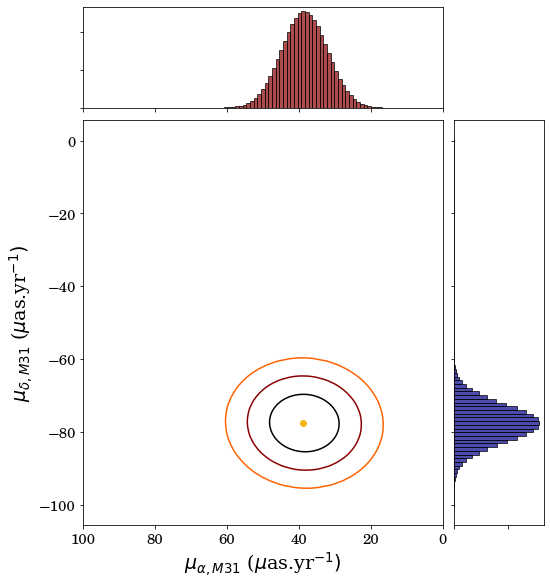

In [243]:
ObjLike = LikelihooD(99, GaiaDataRed, ModelDataRed, [])
ObjLike.Execute()
ObjLike.Plot()

This slightly changes the values found without considering the systematics, indeed before they were of:

- Blue sample: $\mu_{\alpha, M31} = (43.9 \pm 4.9 \, ; \, -27.6 \pm 4.1)\mu as.yr^{-1}$
- Red sample: $\mu_{\delta, M31} = (41.9 \pm 6.4 \, ; \, -72.4 \pm 5.2)\mu as.yr^{-1}$

In [239]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [240]:
%%cython
from math import pi

cdef extern from "math.h":
    double log(double)

cdef double my_log(double x):
    return log(x)

def LikelihoodCFunction(double pm_ra_M31, double pm_dec_M31, double mu_ra_model, double mu_dec_model,
                        double mu_ra_sig_gaia, double mu_dec_sig_gaia, double mu_ra_gaia, double mu_dec_gaia):
    cdef double GaussianCenter_ra, GaussianCenter_dec, PreFactor, ExpRa, ExpDec
    
    GaussianCenter_ra  = pm_ra_M31 + mu_ra_model
    GaussianCenter_dec = pm_dec_M31 + mu_dec_model

    PreFactor = 1/(2*pi*mu_ra_sig_gaia*mu_dec_sig_gaia)    
    ExpRa  = -0.5*((mu_ra_gaia - GaussianCenter_ra)/(mu_ra_sig_gaia))**2
    ExpDec = -0.5*((mu_dec_gaia - GaussianCenter_dec)/(mu_dec_sig_gaia))**2
    
    return my_log(PreFactor) + ExpRa + ExpDec #exp to come back to the L and not ln(L)

def LikelihoodCFunctionCorr(double pm_ra_M31, double pm_dec_M31, double mu_ra_model, double mu_dec_model,
                        double mu_ra_sig_gaia, double mu_dec_sig_gaia, double mu_ra_gaia, 
                        double mu_dec_gaia, double pm_corr):
    cdef double GaussianCenter_ra, GaussianCenter_dec, PreFactor, ExpRa, ExpDec, ExpCor
    
    GaussianCenter_ra  = pm_ra_M31 + mu_ra_model
    GaussianCenter_dec = pm_dec_M31 + mu_dec_model

    PreFactor = 1/(2*pi*mu_ra_sig_gaia*mu_dec_sig_gaia*(1 - pm_corr**2)**(0.5))    
    ExpRa  = -(1/(2*(1 - pm_corr**2)))*((mu_ra_gaia - GaussianCenter_ra)/(mu_ra_sig_gaia))**2
    ExpDec = -(1/(2*(1 - pm_corr**2)))*((mu_dec_gaia - GaussianCenter_dec)/(mu_dec_sig_gaia))**2
    ExpCor =  (1/(2*(1 - pm_corr**2)))*((2*pm_corr*(mu_ra_gaia - GaussianCenter_ra)*(
              mu_dec_gaia - GaussianCenter_dec))/(mu_ra_sig_gaia*mu_dec_sig_gaia))
    
    return my_log(PreFactor) + ExpRa + ExpDec + ExpCor #exp to come back to the L and not ln(L)